# Log of changes from original calculation

* Urban/rural split is now based on MSASIZE instead of URBRUR variable from NHTS. Now "rural" is outside of any MSA, instead of just not in an urbanized region.
* Added an option to include demand from transit trips in addition to private vehicles and taxis.
* Now breaking down into three different times of week: Sa/Su, M/F, and Tu/W/Th.

# Important things to note:
* This provides the *trip* demand, where a trip is point-to-point travel for one or more members of the same household. So if a family of six all takes the bus, that's *one* trip. This has implications for our assumptions about the sharing factor.
* Trips >=300 mi. are thrown out

# To do
* Make sure that we are aligning indexes properly when combining up to final dataset. Previously this wasn't being combined correctly. Look in the notebook for combining things,where I think I do a better job.
* Seasonal variation

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
%matplotlib notebook

## Set up

In [118]:
#Point to a directory containing the NHTS trippub.csv dataset
data_dir = 'C:\\Users\\bgerke.DOMINO0\\Desktop\\NHTS\\'

#Should we include demand from trips on mass transit (public transit, school buses, private shuttles, etc.)?
include_transit = False



In [119]:
#Read in main dataset
trippub_all = pd.read_csv(data_dir+'trippub.csv')
trippub_all.head()
#Trips

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,HTRESDN,SMPLSRCE,R_AGE,EDUC,R_SEX,PRMACT,PROXY,WORKER,DRIVER,WTTRDFIN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
2,30000007,2,1,700,900,120,84.004,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
4,30000007,3,1,845,900,15,2.250,3,0,0,...,750,2,28,2,2,5,2,2,1,80122.686739


In [120]:
trippub_all.columns.values

array(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME',
       'TRVLCMIN', 'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC',
       'VEHID', 'TRWAITTM', 'NUMTRANS', 'TRACCTM', 'DROP_PRK', 'TREGRTM',
       'WHODROVE', 'WHYFROM', 'LOOP_TRIP', 'TRPHHVEH', 'HHMEMDRV',
       'HH_ONTD', 'NONHHCNT', 'NUMONTRP', 'PSGR_FLG', 'PUBTRANS',
       'TRIPPURP', 'DWELTIME', 'TDWKND', 'VMT_MILE', 'DRVR_FLG',
       'WHYTRP1S', 'WHYTRP90', 'ONTD_P1', 'ONTD_P2', 'ONTD_P3', 'ONTD_P4',
       'ONTD_P5', 'ONTD_P6', 'ONTD_P7', 'ONTD_P8', 'ONTD_P9', 'ONTD_P10',
       'ONTD_P11', 'ONTD_P12', 'ONTD_P13', 'TDCASEID', 'TRACC_WLK',
       'TRACC_POV', 'TRACC_BUS', 'TRACC_CRL', 'TRACC_SUB', 'TRACC_OTH',
       'TREGR_WLK', 'TREGR_POV', 'TREGR_BUS', 'TREGR_CRL', 'TREGR_SUB',
       'TREGR_OTH', 'WHYTO', 'TRAVDAY', 'HOMEOWN', 'HHSIZE', 'HHVEHCNT',
       'HHFAMINC', 'DRVRCNT', 'HHSTATE', 'HHSTFIPS', 'NUMADLT',
       'WRKCOUNT', 'TDAYDATE', 'HHRESP', 'LIF_CYC', 'MSACAT', 'MSASIZE',
       'RAIL', 'URBAN', '

In [121]:
#Personal motor vehicle codes from code book
#This is car, suv, van, pickup truck,  motorcycle, RV, rental car
#LEAVES OUT 17-taxis/TNCs, because (I believe) we cannot weight these correctly since must weight by driver. 

pmvcodes = [3,4,5,6,8,9,18]
selection = (trippub_all['TRPTRANS'].isin(pmvcodes)) & (trippub_all['DRVR_FLG']==1)


    
trippub = trippub_all.loc[selection]
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())


611342
220429661377.4252


In [122]:
taxitrips = trippub_all.loc[trippub_all['TRPTRANS']==17].groupby(['HOUSEID','TDAYDATE','STRTTIME']).first()
#The above cuts out duplicate trips, where two people in the same household reported the same taxi trip. Serves
#a similar purpose to restricting by driver flag
trippub = trippub.append(taxitrips)
trippub.reset_index(drop=True, inplace=True)
print(taxitrips['TRPTRANS'].count())
print(taxitrips['WTTRDFIN'].sum())
#Surprisingly few taxi trips...

2394
1615969202.3435988


In [123]:
if include_transit:
    print('Including transit trips in total.')
    #Transit vehicle codes from code book are 10-16 
    trnstcodes = list(range(10,17))
    trnsttrips = trippub_all.loc[trippub_all['TRPTRANS'].isin(trnstcodes)].groupby(['HOUSEID','TDAYDATE','STRTTIME']).first()
    trippub = trippub.append(trnsttrips)
    trippub.reset_index(drop=True, inplace=True)
    print(trnsttrips['TRPTRANS'].count())
    print(trnsttrips['WTTRDFIN'].sum())
else:
    print('Excluding transit trips from total')

Excluding transit trips from total


In [124]:
#Total raw and weighted trip numbers
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())

613736
222045630579.7688


In [125]:
#Print avg mileages by trip type
print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())
print(taxitrips['TRPMILES'].mul(taxitrips['WTTRDFIN']).sum()/taxitrips['WTTRDFIN'].sum())
if include_transit: 
    print(trnsttrips['TRPMILES'].mul(trnsttrips['WTTRDFIN']).sum()/trnsttrips['WTTRDFIN'].sum())

9.543193941031108
8.222858752112181


In [126]:
trippub.tail()

,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DROP_PRK,DRVRCNT,DRVR_FLG,DWELTIME,EDUC,ENDTIME,...,VEHID,VMT_MILE,WHODROVE,WHYFROM,WHYTO,WHYTRP1S,WHYTRP90,WORKER,WRKCOUNT,WTTRDFIN
613731,91,9,4,1,-1,2,-1,108,4,932,...,-1,-1.0,-1,1,3,10,1,1,2,344957.415508
613732,91,9,4,1,-1,2,-1,65,4,1135,...,-1,-1.0,-1,3,1,1,1,1,2,344957.415508
613733,91,9,4,1,-1,2,-1,-9,4,2025,...,-1,-1.0,-1,7,1,1,10,1,2,408975.662752
613734,91,9,4,1,-1,2,-1,40,4,1200,...,-1,-1.0,-1,2,1,1,11,1,2,422950.854805
613735,91,9,4,1,-1,2,-1,-9,4,1300,...,-1,-1.0,-1,1,2,1,11,1,2,422950.854805


In [127]:
#Trim out long road trips
trippub = trippub.loc[trippub['TRPMILES'] < 300]
print(len(trippub))
print(trippub['WTTRDFIN'].sum())

print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())

613205
221835869978.23254
8.90120102812671


In [128]:
#Create Census Division/ Large State category with urban/rural split.
#Also Census region urban/rural split
cdiv = {1:'NENG', 2:'MAT', 3:'ENC', 4:'WNC', 5:'SAT', 6:'ESC', 7:'WSC', 8:'MTN', 9:'PAC'}
creg = {1:'NEAST', 2:'MIDW', 3:'SOUTH', 4:'WEST'}

for k in cdiv.keys():
    trippub.loc[trippub['CENSUS_D']==k, 'CDIVLS'] = cdiv[k]
for k in creg.keys():
    trippub.loc[trippub['CENSUS_R']==k, 'REGION'] = creg[k]

lgst = ['CA', 'NY','FL','TX']

for s in lgst:
    div = cdiv[trippub.loc[trippub['HHSTATE']==s, 'CENSUS_D'].unique()[0]]
    #print reg
    trippub.loc[(trippub['HHSTATE']==s), 'CDIVLS'] = div+'-'+s
    trippub.loc[(trippub['CDIVLS']==div) & (trippub['HHSTATE']!=s), 'CDIVLS'] = div+'-NL' 
    

#Turn urban/rural codes into strings    
trippub['URBRURS'] = 'RUR'
#trippub.loc[trippub['URBRUR'] == 1, 'URBRURS'] = 'URB'
#Instead of the above, divide urban vs rural according to metropolitan statistical area size: all MSAs are urban
trippub.loc[trippub['MSASIZE']<6,'URBRURS'] = 'URB'


print trippub['CDIVLS'].unique()
print trippub['REGION'].unique()
print trippub['URBRURS'].unique()

['SAT-NL' 'ENC' 'MAT-NY' 'MAT-NL' 'PAC-CA' 'WSC-TX' 'PAC-NL' 'ESC' 'MTN'
 'WNC' 'NENG' 'SAT-FL' 'WSC-NL']
['SOUTH' 'MIDW' 'NEAST' 'WEST']
['URB' 'RUR']


In [129]:
#Code different times of week.
wktime = {'SA/SU':[1,7], 'MO/FR':[2,6], 'TU/WE/TH': [3,4,5]}
trippub['WKTIME'] = ''
for k in wktime.keys():
    trippub.loc[trippub['TRAVDAY'].isin(wktime[k]), 'WKTIME'] = k
print trippub['WKTIME'].unique()

['MO/FR' 'TU/WE/TH' 'SA/SU']


In [130]:
#Set mileage bin edges
mibins=[0,2,5,10,20,30,50,100,300]
mibin_labels=pd.Series(mibins[:-1]).astype(str).str.cat(pd.Series(mibins[1:]).astype(str), sep='-')

In [131]:
#Categorize trips by mileage

trippub['MILEBIN'] = pd.cut(trippub['TRPMILES'], mibins, labels=mibin_labels)


In [132]:
#Compute distance histograms (and average distances) by CDLS

dist_hists = trippub.groupby(['CDIVLS', 'URBRURS',
                              'WKTIME','MILEBIN']).agg({'WTTRDFIN':[len, np.sum], 
                                                               'TRPMILES':np.mean,
                                                               'REGION':'first'}
                                                       ).rename(columns=
                                                                {'mean':'AVGDIST',
                                                                 'first':'REGION', 
                                                                 'len':'COUNTSRAW',
                                                                 'sum':'COUNTSWTD'}, level=1)

dist_hists.columns = dist_hists.columns.droplevel(0)
dist_hists

#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

AVGDIST REGION  COUNTSRAW     COUNTSWTD
CDIVLS URBRURS WKTIME   MILEBIN                                            
ENC    RUR     MO/FR    0-2        0.974638   MIDW     2015.0  7.172323e+08
                        2-5        3.229061   MIDW     1272.0  3.689536e+08
                        5-10       7.307186   MIDW      962.0  2.574709e+08
                        10-20     14.369085   MIDW      872.0  2.688098e+08
                        20-30     24.308613   MIDW      367.0  1.130752e+08
                        30-50     38.296500   MIDW      294.0  7.924429e+07
                        50-100    65.738626   MIDW      147.0  3.291124e+07
                        100-300  164.462368   MIDW       68.0  1.262960e+07
               SA/SU    0-2        0.990884   MIDW      900.0  5.904250e+08
                        2-5        3.263062   MIDW      516.0  3.306223e+08
                        5-10       7.174956   MIDW      363.0  2.181214e+08
                        10-20     13.890219   MIDW      374.0  2.274015e+08
                        20-30     24.590622   MIDW      135.0  9.867586e+07
                        30-50     39.594713   MIDW      108.0  7.227111e+07
                        50-100    65.750533   MIDW       92.0  3.914405e+07
                        100-300  157.425613   MIDW       31.0  1.656451e+07
               TU/WE/TH 0-2        0.968638   MIDW     2966.0  8.372957e+08
                        2-5        3.265039   MIDW     1835.0  5.502475e+08
                        5-10       7.273006   MIDW     1437.0  4.489847e+08
                        10-20     14.320166   MIDW     1346.0  5.147868e+08
                        20-30     24.388382   MIDW      558.0  1.765248e+08
                        30-50     38.339401   MIDW      459.0  1.483422e+08
                        50-100    67.393056   MIDW      177.0  4.410430e+07
                        100-300  156.786339   MIDW       59.0  1.006733e+07
       URB     MO/FR    0-2        1.085843   MIDW     5294.0  2.227462e+09
                        2-5        3.300086   MIDW     5525.0  2.255926e+09
                        5-10       7.133211   MIDW     3646.0  1.564843e+09
                        10-20     14.079526   MIDW     2614.0  1.148814e+09
                        20-30     23.939033   MIDW      812.0  4.235249e+08
                        30-50     37.506699   MIDW      505.0  2.503524e+08
...                                     ...    ...        ...           ...
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH      730.0  1.212465e+08
                        10-20     14.095486  SOUTH      696.0  1.252788e+08
                        20-30     24.975269  SOUTH      275.0  4.497832e+07
                        30-50     38.647350  SOUTH      286.0  3.976651e+07
                        50-100    66.814141  SOUTH      170.0  2.805630e+07
                        100-300  177.377809  SOUTH       47.0  6.633365e+06
       URB     MO/FR    0-2        1.109696  SOUTH    10821.0  1.353486e+09
                        2-5        3.313290  SOUTH    11476.0  1.434164e+09
                        5-10       7.115351  SOUTH     7373.0  9.393401e+08
                        10-20     14.128532  SOUTH     5927.0  7.651838e+08
                        20-30     24.046139  SOUTH     2298.0  2.878834e+08
                        30-50     37.094788  SOUTH     1169.0  1.442682e+08
                        50-100    68.503032  SOUTH      408.0  4.765194e+07
                        100-300  170.322644  SOUTH      261.0  3.139168e+07
               SA/SU    0-2        1.101145  SOUTH     3846.0  1.171181e+09
                        2-5        3.304706  SOUTH     4252.0  1.261692e+09
                        5-10       7.121120  SOUTH     2661.0  8.109927e+08
                        10-20     14.151696  SOUTH     1830.0  5.535825e+08
                        20-30     24.027017  SOUTH      686.0  2.161418e+08
                        30-50     37.700176  SOUTH      369.0  1.080243e+08
        

In [133]:
#Check avg mileages
print(dist_hists['AVGDIST'].mul(dist_hists['COUNTSWTD']).sum()/dist_hists['COUNTSWTD'].sum())

8.895831871128166


In [134]:
trippub['STRTHOUR'] = pd.cut(trippub['STRTTIME'], np.arange(25)*100, labels=np.arange(24))

In [135]:
#Compute hourly trip volume profiles by region and urb/rural

hourly_profiles = trippub.groupby(['REGION', 
                                   'URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

In [136]:
hourly_profiles

COUNTSRAW     COUNTSWTD
REGION URBRURS WKTIME   MILEBIN STRTHOUR                         
MIDW   RUR     MO/FR    0-2     0               2.0  2.815297e+06
                                1               1.0  3.220029e+05
                                2               1.0  3.220029e+05
                                3               1.0  4.899141e+06
                                4              16.0  2.741188e+06
                                5              35.0  1.733291e+07
                                6              72.0  3.814189e+07
                                7             153.0  8.994277e+07
                                8             145.0  7.731181e+07
                                9             186.0  1.055746e+08
                                10            186.0  1.054969e+08
                                11            240.0  1.359717e+08
                                12            244.0  1.262910e+08
                                13            190.0  1.185208e+08
                                14            166.0  6.786482e+07
                                15            223.0  1.153466e+08
                                16            209.0  9.737010e+07
                                17            152.0  8.263486e+07
                                18            111.0  6.884659e+07
                                19             61.0  3.242137e+07
                                20             52.0  2.479740e+07
                                21             32.0  3.969142e+07
                                22             17.0  1.808778e+07
                                23              5.0  1.144201e+06
                        2-5     0               2.0  6.533857e+05
                                1               2.0  1.117313e+06
                                3               1.0  1.198312e+05
                                4              14.0  7.852458e+06
                                5              26.0  7.492990e+06
                                6              56.0  2.489896e+07
...                                             ...           ...
WEST   URB     TU/WE/TH 50-100  15             59.0  1.963333e+07
                                16             63.0  3.055456e+07
                                17             33.0  9.498329e+06
                                18             30.0  1.580210e+07
                                19             21.0  4.822107e+06
                                20             24.0  5.872926e+06
                                21              9.0  2.369436e+06
                                22              4.0  8.011899e+05
                                23              3.0  1.173666e+06
                        100-300 1               1.0  1.798080e+05
                                4              15.0  4.734030e+06
                                5              13.0  2.039161e+06
                                6              24.0  7.450835e+06
                                7              24.0  4.284670e+06
                                8              18.0  3.152040e+06
                                9              38.0  7.292988e+06
                                10             25.0  6.222500e+06
                                11             21.0  5.780801e+06
                                12             38.0  9.613410e+06
                                13             18.0  2.309938e+06
                                14             26.0  6.518309e+06
                                15             18.0  4.867113e+06
                                16             22.0  8.864430e+06
                                17             14.0  2.604683e+06
                                18             15.0  1.610080e+06
                                19              8.0  2.029689e+06
                                20              5.0  2.046922e+06
                                21              6.0  1.489950e+06
                

In [137]:
hourly_profiles['TRIPPCT'] = 0
for row in [(a,b,c,d) 
            for a in hourly_profiles.index.levels[0].unique() 
            for b in hourly_profiles.index.levels[1].unique() 
            for c in hourly_profiles.index.levels[2].unique() 
            for d in hourly_profiles.index.levels[3].unique()]:
    pct=hourly_profiles.loc[row,'COUNTSWTD']/(hourly_profiles.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [138]:
hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T

REGION        MIDW                                                    \
URBRURS        RUR                                                     
WKTIME       MO/FR                                                     
MILEBIN        0-2       2-5      5-10     10-20     20-30     30-50   
STRTHOUR                                                               
0         0.002049  0.000982  0.004599  0.010010  0.023396  0.000115   
1         0.000234  0.001680  0.000296  0.000168  0.000000  0.000000   
2         0.000234  0.000000  0.000262  0.000403  0.000000  0.000000   
3         0.003566  0.000180  0.000233  0.000000  0.000627  0.000297   
4         0.001995  0.011806  0.013212  0.005262  0.023125  0.017563   
5         0.012616  0.011266  0.005867  0.033454  0.022184  0.036048   
6         0.027762  0.037435  0.038763  0.066114  0.111719  0.194683   
7         0.065466  0.091562  0.097248  0.105400  0.104641  0.070566   
8         0.056272  0.043826  0.054196  0.044433  0.024659  0.052438   
9         0.076844  0.061717  0.062711  0.032229  0.037728  0.074302   
10        0.076787  0.069472  0.064388  0.046732  0.048167  0.032758   
11        0.098968  0.065435  0.061970  0.036019  0.062070  0.021728   
12        0.091922  0.066571  0.044459  0.055545  0.052947  0.035100   
13        0.086267  0.081652  0.066839  0.052782  0.096770  0.069234   
14        0.049396  0.062752  0.068853  0.074263  0.021926  0.019501   
15        0.083956  0.079708  0.068200  0.119639  0.045164  0.116209   
16        0.070872  0.078908  0.080964  0.114325  0.117532  0.096623   
17        0.060147  0.083459  0.099758  0.087335  0.081802  0.064502   
18        0.050111  0.038970  0.051433  0.027841  0.032926  0.037872   
19        0.023598  0.052390  0.054894  0.004961  0.013947  0.006427   
20        0.018049  0.008285  0.010665  0.028285  0.015694  0.035338   
21        0.028890  0.027453  0.007101  0.040615  0.018207  0.013461   
22        0.013165  0.016491  0.024528  0.013926  0.024111  0.004312   
23        0.000833  0.008003  0.018561  0.000258  0.020656  0.000924   

REGION                                              ...         WEST  \
URBRURS                                             ...          URB   
WKTIME                           SA/SU              ...        SA/SU   
MILEBIN     50-100   100-300       0-2       2-5    ...       50-100   
STRTHOUR                                            ...                
0         0.067353  0.000000  0.000563  0.005047    ...     0.008457   
1         0.000000  0.000000  0.000000  0.000000    ...     0.004124   
2         0.000000  0.000000  0.001215  0.000000    ...     0.000000   
3         0.001223  0.000000  0.000173  0.000000    ...     0.000000   
4         0.023967  0.013819  0.009198  0.008204    ...     0.025443   
5         0.005026  0.186522  0.010562  0.010634    ...     0.018021   
6         0.082755  0.029462  0.017461  0.030186    ...     0.057132   
7         0.006244  0.059029  0.031325  0.025135    ...     0.021586   
8         0.049778  0.101200  0.051030  0.067981    ...     0.043015   
9         0.053263  0.014541  0.094849  0.071229    ...     0.097069   
10        0.024483  0.006992  0.078665  0.095103    ...     0.102955   
11        0.105639  0.049740  0.125434  0.096762    ...     0.062125   
12        0.083987  0.025305  0.089647  0.062436    ...     0.075413   
13        0.115735  0.316100  0.092183  0.088506    ...     0.087584   
14        0.024691  0.111768  0.092122  0.086091    ...     0.042049   
15        0.117456  0.008117  0.071480  0.079868    ...     0.062890   
16        0.095099  0.006447  0.053484  0.059957    ...     0.074971   
17        0.050276  0.054094  0.050587  0.075853    ...     0.066127   
18        0.004521  0.005085  0.034995  0.060803    ...     0.051016   
19        0.087231  0.000000  0.025966  0.018718    ...     0.048792   
20        0.000633  0.011781  0.009681  0.024261    ...     0.022776   
21        0.000000  0.000000  0.030268 

In [139]:
hourly_profiles_agg = trippub.groupby(['URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})

In [140]:
hourly_profiles_agg['TRIPPCT'] = 0
for row in [(a,b,c) 
            for a in hourly_profiles_agg.index.levels[0].unique() 
            for b in hourly_profiles_agg.index.levels[1].unique() 
            for c in hourly_profiles_agg.index.levels[2].unique()]:
    pct=hourly_profiles_agg.loc[row,'COUNTSWTD']/(hourly_profiles_agg.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles_agg.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [141]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME   MILEBIN STRTHOUR                                   
RUR     MO/FR    0-2     0               6.0  3.686144e+06  0.001000
                         1               8.0  9.804437e+06  0.002661
                         2               1.0  3.220029e+05  0.000087
                         3               1.0  4.899141e+06  0.001330
                         4              27.0  3.329577e+06  0.000904
                         5              88.0  3.292373e+07  0.008935
                         6             222.0  8.691726e+07  0.023587
                         7             637.0  2.670100e+08  0.072461
                         8             529.0  2.233983e+08  0.060626
                         9             702.0  2.244169e+08  0.060902
                         10            811.0  2.601519e+08  0.070600
                         11            975.0  3.135245e+08  0.085084
                         12            988.0  3.567213e+08  0.096807
                         13            803.0  2.909382e+08  0.078954
                         14            802.0  2.657854e+08  0.072129
                         15            877.0  3.365339e+08  0.091328
                         16            788.0  3.057050e+08  0.082962
                         17            606.0  2.502709e+08  0.067918
                         18            396.0  1.780279e+08  0.048313
                         19            220.0  9.051126e+07  0.024563
                         20            179.0  7.421489e+07  0.020140
                         21            106.0  5.901752e+07  0.016016
                         22             44.0  2.555890e+07  0.006936
                         23             29.0  2.121847e+07  0.005758
                 2-5     0               6.0  4.572063e+06  0.002038
                         1               4.0  1.554191e+06  0.000693
                         3               2.0  3.235058e+05  0.000144
                         4              32.0  1.362102e+07  0.006072
                         5              82.0  2.866647e+07  0.012778
                         6             207.0  9.225242e+07  0.041121
...                                      ...           ...       ...
URB     TU/WE/TH 50-100  17            168.0  6.232830e+07  0.072522
                         18            114.0  4.301895e+07  0.050055
                         19             65.0  1.411913e+07  0.016428
                         20             68.0  1.104267e+07  0.012849
                         21             36.0  5.331993e+06  0.006204
                         22             23.0  9.409047e+06  0.010948
                         23              8.0  3.762486e+06  0.004378
                 100-300 0               1.0  1.338488e+04  0.000042
                         1               1.0  1.798080e+05  0.000563
                         3               4.0  2.328788e+05  0.000729
                         4              41.0  1.519647e+07  0.047559
                         5              46.0  1.860461e+07  0.058225
                         6              87.0  1.870351e+07  0.058535
                         7             100.0  2.307079e+07  0.072203
                         8             105.0  2.110372e+07  0.066047
                         9             128.0  3.497615e+07  0.109462
                         10             94.0  1.826812e+07  0.057172
                         11            109.0  2.376506e+07  0.074376
                         12            131.0  3.064732e+07  0.095914
                         13             89.0  1.584287e+07  0.049582
                         14            120.0  1.861029e+07  0.058243
                         15             93.0  1.548741e+07  0.048470
                         16             89.0  2.468002e+07  0.077239
                         17             51.0  1.580519e+07  0.049464
                         18             44.0  1.039181e+07  0.032522
                         19      

<IPython.core.display.Javascript object>


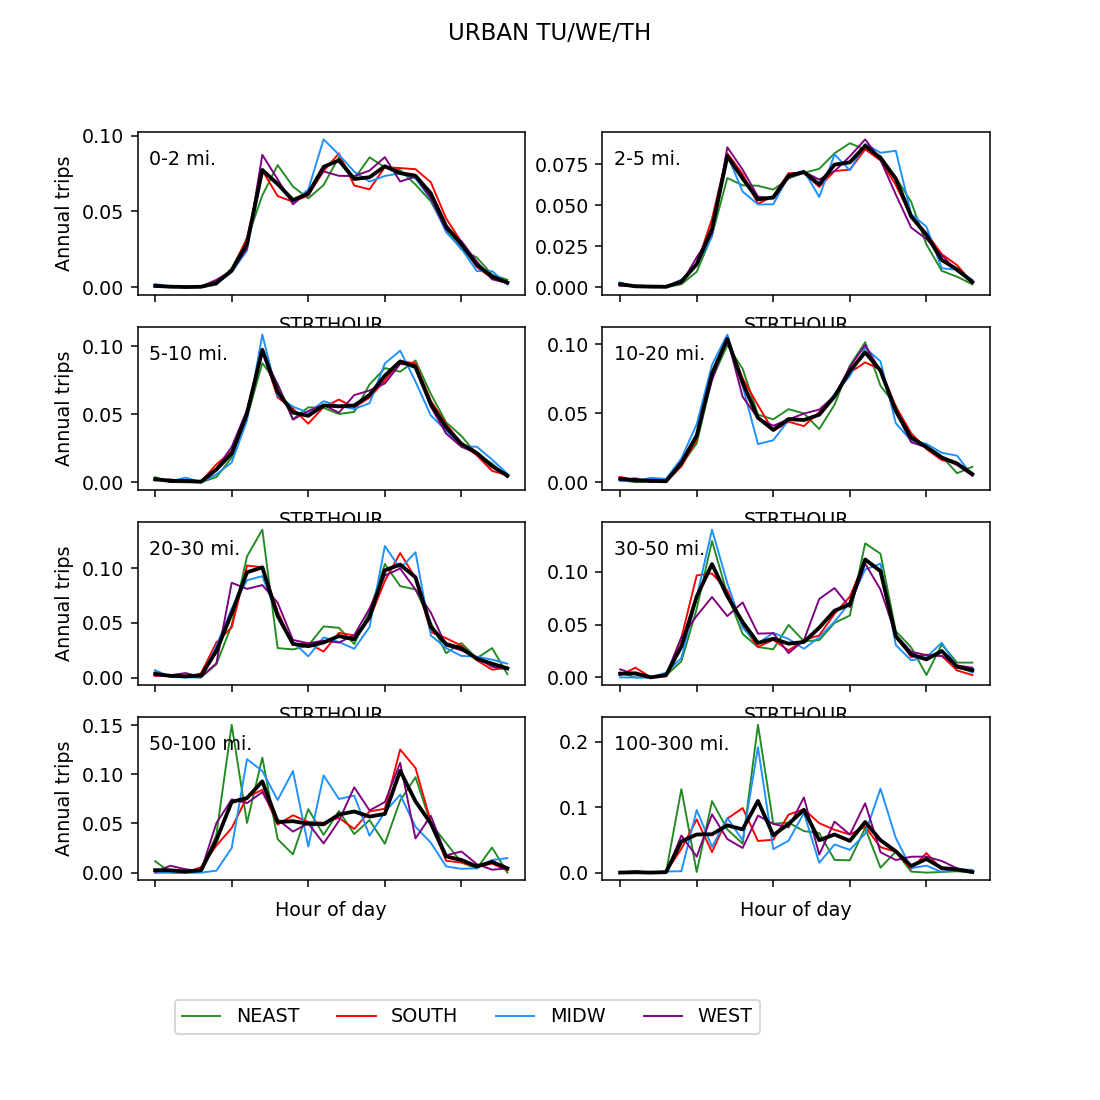

('NEAST', 'URB', 'TU/WE/TH')
('SOUTH', 'URB', 'TU/WE/TH')
('MIDW', 'URB', 'TU/WE/TH')
('WEST', 'URB', 'TU/WE/TH')


In [142]:
def plot_dists_by_region(plotdata, regions=['NEAST','SOUTH','MIDW','WEST'], urbrur='URB', wktime='WEEKDAY',
                         alldata = None,
                         colors=None):
    fig = plt.figure()
    gs = gridspec.GridSpec(nrows=4, ncols=2, bottom=0.2)

    for i in range(len(mibins[:-1])):
        fig.add_subplot(gs[i/2, i%2])

    axs = fig.axes
    
    if not colors:
        colors=['forestgreen','red','dodgerblue','purple']

    #plotdata = dists.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
    for i, reg in enumerate(regions):
        sel=(reg,urbrur,wktime)
        print sel
        #plotdata = dists.loc[sel].unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
        #plotdata.index = np.arange(24)
        plotdata[sel].plot(subplots=True, legend=None, color=colors[i], ax=axs, linewidth=1)

    if alldata is not None:
        alldata[(urbrur,wktime)].plot(subplots=True, legend=None,color='k', ax=axs, linewidth=2)
    for i, ax in enumerate(axs):
        col = plotdata[sel].columns[i]
        miles = col.split('-')
        ax.annotate(str(miles[0])+'-'+str(miles[1])+' mi.', [0.03,0.8], xycoords='axes fraction')
        if i > 5:
            ax.set_xlabel('Hour of day')
            
        if i % 2 == 0:
            ax.set_ylabel('Annual trips')

    plt.legend(ax.lines, regions,ncol=4, loc=2, bbox_to_anchor=(0.15,0.1), bbox_transform=fig.transFigure)
    
    if urbrur == 'URB': 
        urname='URBAN' 
    else: 
        urname='RURAL'
    fig.suptitle(urname+' '+wktime)
    
plt.rcParams['figure.figsize'] = [8, 8]    
plotdata = hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
alldata = hourly_profiles_agg.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
plot_dists_by_region(plotdata, urbrur='URB', wktime='TU/WE/TH', alldata=alldata)

In [143]:
dist_hour_hists = dist_hists.copy()
dist_hour_hists.rename(columns={'COUNTSRAW':'NRAW', 'COUNTSWTD':'NWTD'},inplace=True)
dist_hour_hists

AVGDIST REGION     NRAW          NWTD
CDIVLS URBRURS WKTIME   MILEBIN                                          
ENC    RUR     MO/FR    0-2        0.974638   MIDW   2015.0  7.172323e+08
                        2-5        3.229061   MIDW   1272.0  3.689536e+08
                        5-10       7.307186   MIDW    962.0  2.574709e+08
                        10-20     14.369085   MIDW    872.0  2.688098e+08
                        20-30     24.308613   MIDW    367.0  1.130752e+08
                        30-50     38.296500   MIDW    294.0  7.924429e+07
                        50-100    65.738626   MIDW    147.0  3.291124e+07
                        100-300  164.462368   MIDW     68.0  1.262960e+07
               SA/SU    0-2        0.990884   MIDW    900.0  5.904250e+08
                        2-5        3.263062   MIDW    516.0  3.306223e+08
                        5-10       7.174956   MIDW    363.0  2.181214e+08
                        10-20     13.890219   MIDW    374.0  2.274015e+08
                        20-30     24.590622   MIDW    135.0  9.867586e+07
                        30-50     39.594713   MIDW    108.0  7.227111e+07
                        50-100    65.750533   MIDW     92.0  3.914405e+07
                        100-300  157.425613   MIDW     31.0  1.656451e+07
               TU/WE/TH 0-2        0.968638   MIDW   2966.0  8.372957e+08
                        2-5        3.265039   MIDW   1835.0  5.502475e+08
                        5-10       7.273006   MIDW   1437.0  4.489847e+08
                        10-20     14.320166   MIDW   1346.0  5.147868e+08
                        20-30     24.388382   MIDW    558.0  1.765248e+08
                        30-50     38.339401   MIDW    459.0  1.483422e+08
                        50-100    67.393056   MIDW    177.0  4.410430e+07
                        100-300  156.786339   MIDW     59.0  1.006733e+07
       URB     MO/FR    0-2        1.085843   MIDW   5294.0  2.227462e+09
                        2-5        3.300086   MIDW   5525.0  2.255926e+09
                        5-10       7.133211   MIDW   3646.0  1.564843e+09
                        10-20     14.079526   MIDW   2614.0  1.148814e+09
                        20-30     23.939033   MIDW    812.0  4.235249e+08
                        30-50     37.506699   MIDW    505.0  2.503524e+08
...                                     ...    ...      ...           ...
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH    730.0  1.212465e+08
                        10-20     14.095486  SOUTH    696.0  1.252788e+08
                        20-30     24.975269  SOUTH    275.0  4.497832e+07
                        30-50     38.647350  SOUTH    286.0  3.976651e+07
                        50-100    66.814141  SOUTH    170.0  2.805630e+07
                        100-300  177.377809  SOUTH     47.0  6.633365e+06
       URB     MO/FR    0-2        1.109696  SOUTH  10821.0  1.353486e+09
                        2-5        3.313290  SOUTH  11476.0  1.434164e+09
                        5-10       7.115351  SOUTH   7373.0  9.393401e+08
                        10-20     14.128532  SOUTH   5927.0  7.651838e+08
                        20-30     24.046139  SOUTH   2298.0  2.878834e+08
                        30-50     37.094788  SOUTH   1169.0  1.442682e+08
                        50-100    68.503032  SOUTH    408.0  4.765194e+07
                        100-300  170.322644  SOUTH    261.0  3.139168e+07
               SA/SU    0-2        1.101145  SOUTH   3846.0  1.171181e+09
                        2-5        3.304706  SOUTH   4252.0  1.261692e+09
                        5-10       7.121120  SOUTH   2661.0  8.109927e+08
                        10-20     14.151696  SOUTH   1830.0  5.535825e+08
                        20-30     24.027017  SOUTH    686.0  2.161418e+08
                        30-50     37.700176  SOUTH    369.0  1.080243e+08
                        50-100    71.025019  SOUTH    210.0  7.147218e+07
                        100-300  165.758

In [144]:
hcols=[]
for h in range(24):
    col='NWTD_'+format(h,'02d')
    hcols.append(col)
    dist_hour_hists[h]=0
    
dist_hour_hists

AVGDIST REGION     NRAW          NWTD  0  \
CDIVLS URBRURS WKTIME   MILEBIN                                                
ENC    RUR     MO/FR    0-2        0.974638   MIDW   2015.0  7.172323e+08  0   
                        2-5        3.229061   MIDW   1272.0  3.689536e+08  0   
                        5-10       7.307186   MIDW    962.0  2.574709e+08  0   
                        10-20     14.369085   MIDW    872.0  2.688098e+08  0   
                        20-30     24.308613   MIDW    367.0  1.130752e+08  0   
                        30-50     38.296500   MIDW    294.0  7.924429e+07  0   
                        50-100    65.738626   MIDW    147.0  3.291124e+07  0   
                        100-300  164.462368   MIDW     68.0  1.262960e+07  0   
               SA/SU    0-2        0.990884   MIDW    900.0  5.904250e+08  0   
                        2-5        3.263062   MIDW    516.0  3.306223e+08  0   
                        5-10       7.174956   MIDW    363.0  2.181214e+08  0   
                        10-20     13.890219   MIDW    374.0  2.274015e+08  0   
                        20-30     24.590622   MIDW    135.0  9.867586e+07  0   
                        30-50     39.594713   MIDW    108.0  7.227111e+07  0   
                        50-100    65.750533   MIDW     92.0  3.914405e+07  0   
                        100-300  157.425613   MIDW     31.0  1.656451e+07  0   
               TU/WE/TH 0-2        0.968638   MIDW   2966.0  8.372957e+08  0   
                        2-5        3.265039   MIDW   1835.0  5.502475e+08  0   
                        5-10       7.273006   MIDW   1437.0  4.489847e+08  0   
                        10-20     14.320166   MIDW   1346.0  5.147868e+08  0   
                        20-30     24.388382   MIDW    558.0  1.765248e+08  0   
                        30-50     38.339401   MIDW    459.0  1.483422e+08  0   
                        50-100    67.393056   MIDW    177.0  4.410430e+07  0   
                        100-300  156.786339   MIDW     59.0  1.006733e+07  0   
       URB     MO/FR    0-2        1.085843   MIDW   5294.0  2.227462e+09  0   
                        2-5        3.300086   MIDW   5525.0  2.255926e+09  0   
                        5-10       7.133211   MIDW   3646.0  1.564843e+09  0   
                        10-20     14.079526   MIDW   2614.0  1.148814e+09  0   
                        20-30     23.939033   MIDW    812.0  4.235249e+08  0   
                        30-50     37.506699   MIDW    505.0  2.503524e+08  0   
...                                     ...    ...      ...           ... ..   
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH    730.0  1.212465e+08  0   
                        10-20     14.095486  SOUTH    696.0  1.252788e+08  0   
                        20-30     24.975269  SOUTH    275.0  4.497832e+07  0   
                        30-50     38.647350  SOUTH    286.0  3.976651e+07  0   
                        50-100    66.814141  SOUTH    170.0  2.805630e+07  0   
                        100-300  177.377809  SOUTH     47.0  6.633365e+06  0   
       URB     MO/FR    0-2        1.109696  SOUTH  10821.0  1.353486e+09  0   
                        2-5        3.313290  SOUTH  11476.0  1.434164e+09  0   
                        5-10       7.115351  SOUTH   7373.0  9.393401e+08  0   
                        10-20     14.128532  SOUTH   5927.0  7.651838e+08  0   
                        20-30     24.046139  SOUTH   2298.0  2.878834e+08  0   
                        30-50     37.094788  SOUTH   1169.0  1.442682e+08  0   
                        50-100    68.503032  SOUTH    408.0  4.765194e+07  0   
                        100-300  170.322644  SOUTH    261.0  3.139168e+07  0   
               SA/SU    0-2        1.101145  SOUTH   3846.0  1.171181e+09  0   
                        2-5        3.304706  SOUTH   4252.0  1.261692e+09  0   
                        5-10       7.121120  SOUTH   2661.0  8.109927e+08  0   
                        10-20     14

In [145]:
for reg in dist_hists.index.levels[0]:
    print reg
    dist_hour_hists.loc[reg,range(24)] = \
        hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(\
                                            dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.loc[dist_hists.loc[reg].index].values
        #The final reindexing by dist_hists.loc[reg].index is essential to get the rows in the right order!

dist_hour_hists
#hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T

ENC
ESC
MAT-NL
MAT-NY
MTN
NENG
PAC-CA
PAC-NL
SAT-FL
SAT-NL
WNC
WSC-NL
WSC-TX


AVGDIST REGION     NRAW          NWTD  \
CDIVLS URBRURS WKTIME   MILEBIN                                             
ENC    RUR     MO/FR    0-2        0.974638   MIDW   2015.0  7.172323e+08   
                        2-5        3.229061   MIDW   1272.0  3.689536e+08   
                        5-10       7.307186   MIDW    962.0  2.574709e+08   
                        10-20     14.369085   MIDW    872.0  2.688098e+08   
                        20-30     24.308613   MIDW    367.0  1.130752e+08   
                        30-50     38.296500   MIDW    294.0  7.924429e+07   
                        50-100    65.738626   MIDW    147.0  3.291124e+07   
                        100-300  164.462368   MIDW     68.0  1.262960e+07   
               SA/SU    0-2        0.990884   MIDW    900.0  5.904250e+08   
                        2-5        3.263062   MIDW    516.0  3.306223e+08   
                        5-10       7.174956   MIDW    363.0  2.181214e+08   
                        10-20     13.890219   MIDW    374.0  2.274015e+08   
                        20-30     24.590622   MIDW    135.0  9.867586e+07   
                        30-50     39.594713   MIDW    108.0  7.227111e+07   
                        50-100    65.750533   MIDW     92.0  3.914405e+07   
                        100-300  157.425613   MIDW     31.0  1.656451e+07   
               TU/WE/TH 0-2        0.968638   MIDW   2966.0  8.372957e+08   
                        2-5        3.265039   MIDW   1835.0  5.502475e+08   
                        5-10       7.273006   MIDW   1437.0  4.489847e+08   
                        10-20     14.320166   MIDW   1346.0  5.147868e+08   
                        20-30     24.388382   MIDW    558.0  1.765248e+08   
                        30-50     38.339401   MIDW    459.0  1.483422e+08   
                        50-100    67.393056   MIDW    177.0  4.410430e+07   
                        100-300  156.786339   MIDW     59.0  1.006733e+07   
       URB     MO/FR    0-2        1.085843   MIDW   5294.0  2.227462e+09   
                        2-5        3.300086   MIDW   5525.0  2.255926e+09   
                        5-10       7.133211   MIDW   3646.0  1.564843e+09   
                        10-20     14.079526   MIDW   2614.0  1.148814e+09   
                        20-30     23.939033   MIDW    812.0  4.235249e+08   
                        30-50     37.506699   MIDW    505.0  2.503524e+08   
...                                     ...    ...      ...           ...   
WSC-TX RUR     TU/WE/TH 5-10       7.215860  SOUTH    730.0  1.212465e+08   
                        10-20     14.095486  SOUTH    696.0  1.252788e+08   
                        20-30     24.975269  SOUTH    275.0  4.497832e+07   
                        30-50     38.647350  SOUTH    286.0  3.976651e+07   
                        50-100    66.814141  SOUTH    170.0  2.805630e+07   
                        100-300  177.377809  SOUTH     47.0  6.633365e+06   
       URB     MO/FR    0-2        1.109696  SOUTH  10821.0  1.353486e+09   
                        2-5        3.313290  SOUTH  11476.0  1.434164e+09   
                        5-10       7.115351  SOUTH   7373.0  9.393401e+08   
                        10-20     14.128532  SOUTH   5927.0  7.651838e+08   
                        20-30     24.046139  SOUTH   2298.0  2.878834e+08   
                        30-50     37.094788  SOUTH   1169.0  1.442682e+08   
                        50-100    68.503032  SOUTH    408.0  4.765194e+07   
                        100-300  170.322644  SOUTH    261.0  3.139168e+07   
               SA/SU    0-2        1.101145  SOUTH   3846.0  1.171181e+09   
                        2-5        3.304706  SOUTH   4252.0  1.261692e+09   
                        5-10       7.121120  SOUTH   2661.0  8.109927e+08   
                        10-20     14.151696  SOUTH   1830.0  5.535825e+08   
                        20-30     24.027017  SOUTH    686.0  2.161418e+08   
                        30-50   

In [146]:
hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.loc[dist_hour_hists.loc[reg].index]

STRTHOUR                            0             1             2   \
URBRURS WKTIME   MILEBIN                                             
RUR     MO/FR    0-2      2.338365e+05  6.219602e+05  2.042677e+04   
                 2-5      2.751365e+05  9.352775e+04  0.000000e+00   
                 5-10     4.169754e+05  3.893117e+04  2.055373e+04   
                 10-20    3.572847e+05  1.536739e+04  1.926913e+04   
                 20-30    2.678795e+05  1.470129e+04  6.112997e+03   
                 30-50    3.411623e+04  6.281811e+04  5.112861e+03   
                 50-100   4.776816e+05  4.132439e+04  9.523522e+03   
                 100-300  4.963179e+04  0.000000e+00  0.000000e+00   
        SA/SU    0-2      4.390632e+05  1.621744e+04  1.276616e+05   
                 2-5      2.323923e+05  3.666807e+04  0.000000e+00   
                 5-10     5.510772e+04  4.769798e+04  9.084930e+02   
                 10-20    6.489021e+04  2.200600e+05  2.725721e+05   
                 20-30    0.000000e+00  9.889875e+03  0.000000e+00   
                 30-50    0.000000e+00  2.867928e+05  0.000000e+00   
                 50-100   5.904606e+03  4.484626e+04  0.000000e+00   
                 100-300  2.511856e+03  0.000000e+00  0.000000e+00   
        TU/WE/TH 0-2      8.639041e+05  2.641705e+05  1.294229e+05   
                 2-5      5.852606e+04  4.157160e+05  2.245822e+05   
                 5-10     2.626048e+05  6.046491e+03  6.233537e+04   
                 10-20    2.244880e+05  8.545876e+04  0.000000e+00   
                 20-30    1.063475e+05  2.176601e+03  1.155564e+05   
                 30-50    1.409887e+04  1.101809e+04  7.589959e+04   
                 50-100   0.000000e+00  6.841933e+04  0.000000e+00   
                 100-300  0.000000e+00  5.619879e+05  0.000000e+00   
URB     MO/FR    0-2      3.317757e+06  9.202992e+05  1.058333e+06   
                 2-5      3.201510e+06  2.008952e+06  2.851754e+05   
                 5-10     3.506010e+06  1.286520e+06  4.495254e+05   
                 10-20    1.970678e+06  1.064622e+06  2.522935e+06   
                 20-30    9.619586e+05  6.132861e+05  1.765619e+05   
                 30-50    2.378406e+05  1.099857e+06  4.052499e+05   
                 50-100   1.946075e+05  4.408927e+04  0.000000e+00   
                 100-300  2.282337e+04  0.000000e+00  0.000000e+00   
        SA/SU    0-2      1.162957e+06  2.835760e+06  2.367734e+05   
                 2-5      3.008188e+06  3.462277e+06  2.431750e+05   
                 5-10     5.417354e+06  1.687685e+06  1.028424e+06   
                 10-20    3.696539e+06  2.174839e+06  2.315834e+05   
                 20-30    9.175454e+05  8.179686e+05  9.158166e+04   
                 30-50    3.822639e+05  4.777262e+05  7.638749e+04   
                 50-100   2.762520e+05  2.050036e+05  1.609143e+05   
                 100-300  1.670667e+05  1.988200e+05  0.000000e+00   
        TU/WE/TH 0-2      1.812970e+06  6.901870e+05  2.347542e+05   
                 2-5      3.941706e+06  1.204058e+06  8.329002e+05   
                 5-10     3.593209e+06  1.625128e+06  1.665876e+06   
                 10-20    3.144429e+06  1.875322e+06  1.523795e+06   
                 20-30    1.531410e+06  7.293102e+05  5.366075e+05   
                 30-50    7.875700e+05  8.779468e+05  2.081429e+04   
                 50-100   1.417951e+05  1.346022e+05  6.087686e+04   
                 100-300  1.679257e+03  2.255858e+04  0.000000e+00   

STRTHOUR                            3             4             5   \
URBRURS WKTIME   MILEBIN                                             
RUR     MO/FR    0-2      3.107849e+05  2.112170e+05  2.088569e+06   
                 2-5      1.946785e+04  8.196826e+05  1.725084e+06   
                 5-10     4.310575e+04  4.721365e+05  8.997774e+05   
                 10-20    3.161249e+03  3.753502e+05  1.780424e+06   
                 20-30    5.065931e+04  3.558228e+05  5.880137e+05   
         

In [147]:
#double-check avg mileage again
dist_hour_hists[range(24)].mul(dist_hour_hists['AVGDIST'], axis=0).sum(axis=1).sum()/dist_hour_hists[range(24)].sum(axis=1).sum()


8.895831871128166

In [148]:
dist_hour_hists[range(24)].sum(axis=1)

CDIVLS  URBRURS  WKTIME    MILEBIN
ENC     RUR      MO/FR     0-2        7.172323e+08
                           2-5        3.689536e+08
                           5-10       2.574709e+08
                           10-20      2.688098e+08
                           20-30      1.130752e+08
                           30-50      7.924429e+07
                           50-100     3.291124e+07
                           100-300    1.262960e+07
                 SA/SU     0-2        5.904250e+08
                           2-5        3.306223e+08
                           5-10       2.181214e+08
                           10-20      2.274015e+08
                           20-30      9.867586e+07
                           30-50      7.227111e+07
                           50-100     3.914405e+07
                           100-300    1.656451e+07
                 TU/WE/TH  0-2        8.372957e+08
                           2-5        5.502475e+08
                           5-10       4.489847e

<IPython.core.display.Javascript object>


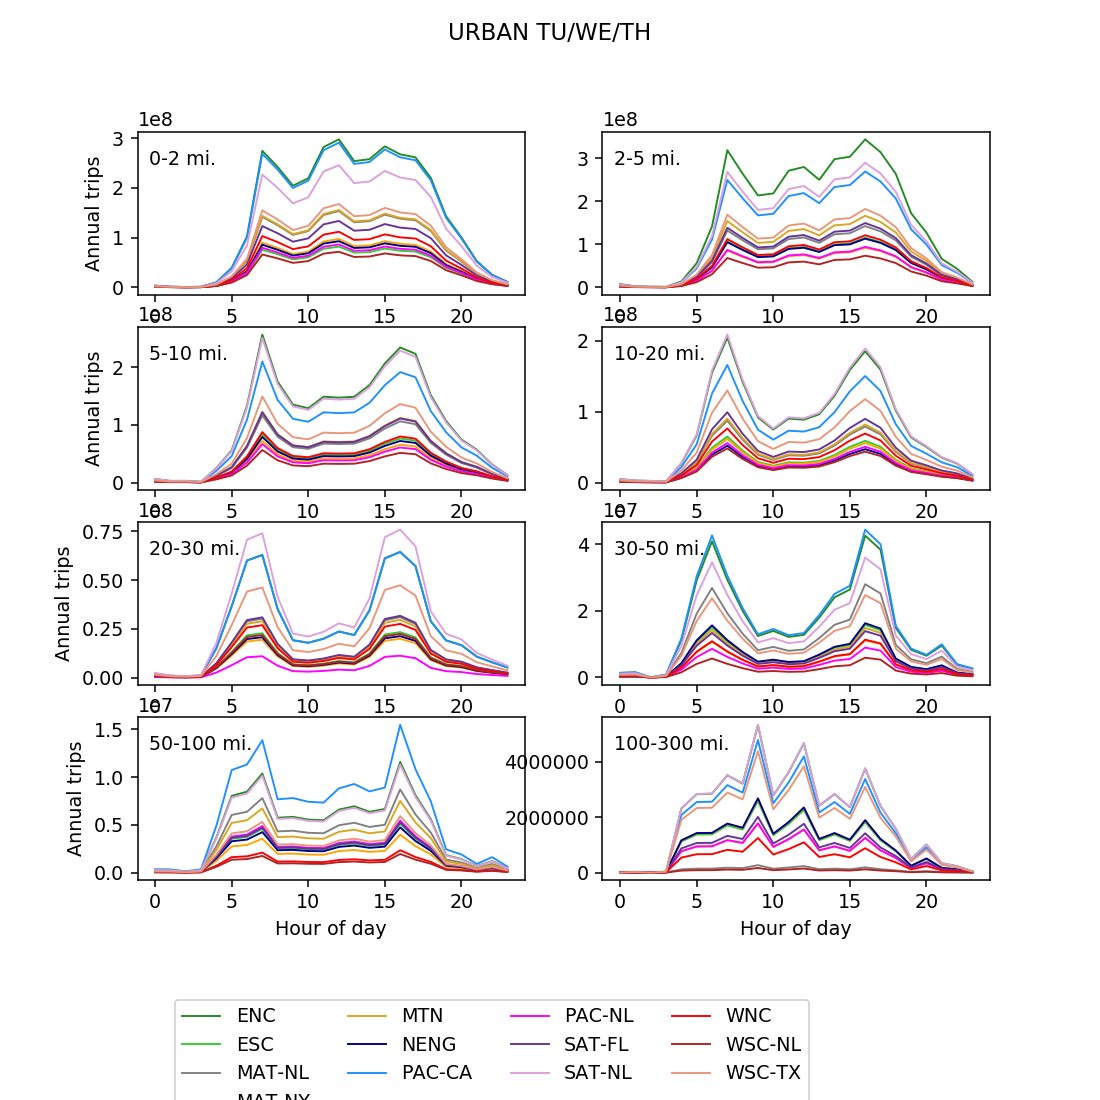

('ENC', 'URB', 'TU/WE/TH')
('ESC', 'URB', 'TU/WE/TH')
('MAT-NL', 'URB', 'TU/WE/TH')
('MAT-NY', 'URB', 'TU/WE/TH')
('MTN', 'URB', 'TU/WE/TH')
('NENG', 'URB', 'TU/WE/TH')
('PAC-CA', 'URB', 'TU/WE/TH')
('PAC-NL', 'URB', 'TU/WE/TH')
('SAT-FL', 'URB', 'TU/WE/TH')
('SAT-NL', 'URB', 'TU/WE/TH')
('WNC', 'URB', 'TU/WE/TH')
('WSC-NL', 'URB', 'TU/WE/TH')
('WSC-TX', 'URB', 'TU/WE/TH')


In [149]:
regions = dist_hour_hists.index.levels[0]
len(regions)
colors=['forestgreen','limegreen','gray', 'orange', 'goldenrod','darkblue','dodgerblue','magenta','rebeccapurple','plum',
       'red','firebrick','darksalmon']
plot_dists_by_region(dist_hour_hists[range(24)].T,regions=regions,colors=colors, urbrur='URB',wktime='TU/WE/TH')

In [150]:
if include_transit:
    tag = 'with_transit'
else:
    tag='no_transit'
hourly_profiles_agg.to_csv(data_dir+'\\binned_dists\\hourly_profiles_urb_rur_'+tag+'.csv')
dist_hists.drop('REGION', axis=1).to_csv(data_dir+'\\binned_dists\\dist_hists_by_region_'+tag+'.csv') #drop region to avoid confusion

In [151]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME   MILEBIN STRTHOUR                                   
RUR     MO/FR    0-2     0               6.0  3.686144e+06  0.001000
                         1               8.0  9.804437e+06  0.002661
                         2               1.0  3.220029e+05  0.000087
                         3               1.0  4.899141e+06  0.001330
                         4              27.0  3.329577e+06  0.000904
                         5              88.0  3.292373e+07  0.008935
                         6             222.0  8.691726e+07  0.023587
                         7             637.0  2.670100e+08  0.072461
                         8             529.0  2.233983e+08  0.060626
                         9             702.0  2.244169e+08  0.060902
                         10            811.0  2.601519e+08  0.070600
                         11            975.0  3.135245e+08  0.085084
                         12            988.0  3.567213e+08  0.096807
                         13            803.0  2.909382e+08  0.078954
                         14            802.0  2.657854e+08  0.072129
                         15            877.0  3.365339e+08  0.091328
                         16            788.0  3.057050e+08  0.082962
                         17            606.0  2.502709e+08  0.067918
                         18            396.0  1.780279e+08  0.048313
                         19            220.0  9.051126e+07  0.024563
                         20            179.0  7.421489e+07  0.020140
                         21            106.0  5.901752e+07  0.016016
                         22             44.0  2.555890e+07  0.006936
                         23             29.0  2.121847e+07  0.005758
                 2-5     0               6.0  4.572063e+06  0.002038
                         1               4.0  1.554191e+06  0.000693
                         3               2.0  3.235058e+05  0.000144
                         4              32.0  1.362102e+07  0.006072
                         5              82.0  2.866647e+07  0.012778
                         6             207.0  9.225242e+07  0.041121
...                                      ...           ...       ...
URB     TU/WE/TH 50-100  17            168.0  6.232830e+07  0.072522
                         18            114.0  4.301895e+07  0.050055
                         19             65.0  1.411913e+07  0.016428
                         20             68.0  1.104267e+07  0.012849
                         21             36.0  5.331993e+06  0.006204
                         22             23.0  9.409047e+06  0.010948
                         23              8.0  3.762486e+06  0.004378
                 100-300 0               1.0  1.338488e+04  0.000042
                         1               1.0  1.798080e+05  0.000563
                         3               4.0  2.328788e+05  0.000729
                         4              41.0  1.519647e+07  0.047559
                         5              46.0  1.860461e+07  0.058225
                         6              87.0  1.870351e+07  0.058535
                         7             100.0  2.307079e+07  0.072203
                         8             105.0  2.110372e+07  0.066047
                         9             128.0  3.497615e+07  0.109462
                         10             94.0  1.826812e+07  0.057172
                         11            109.0  2.376506e+07  0.074376
                         12            131.0  3.064732e+07  0.095914
                         13             89.0  1.584287e+07  0.049582
                         14            120.0  1.861029e+07  0.058243
                         15             93.0  1.548741e+07  0.048470
                         16             89.0  2.468002e+07  0.077239
                         17             51.0  1.580519e+07  0.049464
                         18             44.0  1.039181e+07  0.032522
                         19      